In [1]:
# %load retinanet_test.py
#!/usr/bin/env python

# In[24]:


import time
import os
import copy
import argparse
import pdb
import collections
import sys

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torchvision

import pydicom
import skimage.io
import skimage.transform
import skimage.color
import skimage
import cv2
from PIL import Image

import matplotlib.pyplot as plt

import model
from anchors import Anchors
import losses
from dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, UnNormalizer, Normalizer
from torch.utils.data import Dataset, DataLoader

import coco_eval
import csv_eval

assert torch.__version__.split('.')[1] == '4'

print('CUDA available: {}'.format(torch.cuda.is_available()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#参数
NAME="RSNA"
DATA_PATH = "/data/krf/dataset"
CSV_TRAIN = DATA_PATH + "/csv_train.csv"
CSV_VAL = DATA_PATH + "/csv_val.csv"
CSV_CLASSES = DATA_PATH + "/classes.csv"
TEST_PATH = DATA_PATH +"/stage_1_test_images"


CUDA available: True


In [3]:
from mydataloader import  MyDataset,TestDataset,NormalizerTest,ResizerTest,collaterTest

dataset_test = TestDataset(TEST_PATH,transform=transforms.Compose([NormalizerTest(), ResizerTest()]))
print(len(dataset_test))

sampler_test = AspectRatioBasedSampler(dataset_test, batch_size=1, drop_last=False)
dataloader_test = DataLoader(dataset_test, num_workers=1, collate_fn=collaterTest, batch_sampler=sampler_test)

#retinanet = torch.load("weights_stage1/0_final_seresnext101.pt")
retinanet = torch.load("weights/model_final.pt")
use_gpu = True

if use_gpu:
    retinanet = retinanet.cuda()

retinanet.eval()

unnormalize = UnNormalizer()

#def draw_caption(image, box, caption):

#    b = np.array(box).astype(int)
#    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
#    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)

Using TensorFlow backend.


1000


In [4]:

# In[1]:


filepath = "submission_stage_1.csv"
with open(filepath, 'w') as file:
    file.write("patientId,PredictionString\n")
    for idx, data in enumerate(dataloader_test):
        patientId = os.path.splitext(os.path.basename(data['names'][0]))[0]
        print(patientId)
        file.write(patientId+",")
        with torch.no_grad():
            st = time.time()
            try:
                scores, classification, transformed_anchors = retinanet(data['img'].cuda().float())
                print('Elapsed time: {}'.format(time.time()-st))
                idxs = np.where(scores>0.1)
                img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()

                img[img<0] = 0
                img[img>255] = 255

                img = np.transpose(img, (1, 2, 0))

                
                #img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
                
                outstr = ""#输出到csv中
                resize_factor = 2 #输入的是512，原图像是1024
                for j in range(idxs[0].shape[0]):
                    bbox = transformed_anchors[idxs[0][j], :]
                    x1 = int(bbox[0])
                    y1 = int(bbox[1])
                    x2 = int(bbox[2])
                    y2 = int(bbox[3])
                    #label_name = dataset_val.labels[int(classification[idxs[0][j]])]
                    #draw_caption(img, (x1, y1, x2, y2), "1")

                    #cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)
                    #print(label_name)
                    width = x2 - x1;
                    height = y2 - y1
                    outstr += ' '
                    s = scores[idxs[0][j]].cpu().numpy()
                    print(s)
                    outstr += str(s)
                    outstr += ' '
                    bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, width*resize_factor, height*resize_factor)
                    print(bboxes_str)
                    outstr += bboxes_str
            except Exception as e:
                print(e)
                continue 
            
            #cv2.imshow('img', img)
            #cv2.waitKey(0)
            file.write(outstr+"\n")
        


# In[ ]:


0fc18a4c-0666-4287-a25d-e295bcb18351


/data/krf/anaconda/anaconda3/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Elapsed time: 0.7626934051513672
29cfef18-40c3-489f-adcf-05bd93765b9d
Elapsed time: 0.2937781810760498
19d2c68d-abe7-4575-9ee5-d84b9ff656be
Elapsed time: 0.4846618175506592
11fcbe52-87f7-4074-85ac-153d5f255e35
Elapsed time: 0.4309723377227783
0.157976
508 364 270 508
0.13157956
134 334 256 450
301f54f3-b074-4fa9-9db2-d303fbbf54f0
Elapsed time: 0.2954874038696289
111ce23b-b829-4622-b737-68df649d7393
Elapsed time: 0.371349573135376
20527dda-ec34-4c48-9e6a-c03e0d7d0ff4
Elapsed time: 0.4087250232696533
1dcc3cdf-c92f-42d1-a0fb-3d0ee823a67a
Elapsed time: 0.422839879989624
26e0313c-ca69-42dd-946e-5e0fa33c7e1a
Elapsed time: 0.2825438976287842
1260a8e0-dad4-4b75-8448-0c54c1e21f84
Elapsed time: 0.27904844284057617
03cf39fd-692c-46db-80d2-f1efb09b0e31
Elapsed time: 0.43796229362487793
121ae1f2-0e8e-43f3-8dfc-93ffc2cfff22
Elapsed time: 0.3597743511199951
1bdb5d23-e594-4556-a8dc-0017e6bc5bf9
Elapsed time: 0.4602079391479492
04e9f692-f3d6-496b-ae0c-905137cc1f84
Elapsed time: 0.549933910369873
2afaf9

Elapsed time: 0.40932679176330566
13f9e2d3-1288-46f8-86da-f19e69bbacf7
Elapsed time: 0.20210552215576172
2baa8ae3-27e1-4193-b51e-68e2a1cc516a
Elapsed time: 0.30864882469177246
2837efbb-3c55-436d-8de7-58608bf3245a
Elapsed time: 0.39494967460632324
04158595-a45e-402c-94e9-df6fce1bb6bf
Elapsed time: 0.4188709259033203
19a62d7a-3d7d-4b5b-8dca-3247af94f339
Elapsed time: 0.37860941886901855
1f89239e-8271-4c33-abbc-7c018723b4c4
Elapsed time: 0.47865867614746094
c19b8a3b-ab4e-4a73-8e13-ec0a84b6b6c7
Elapsed time: 0.2682795524597168
c1cf3255-d734-4980-bfe0-967902ad7ed9
Elapsed time: 0.5266449451446533
2ec88120-5cef-45a0-b9d6-629fdf99ab8c
Elapsed time: 0.41628122329711914
0479d585-4e1e-44b3-aabe-4aa8437a54c5
Elapsed time: 0.2706735134124756
106d08b7-b1b7-4ca1-be8d-8de94d2ef682
Elapsed time: 0.3830087184906006
107f84d9-65b3-4a11-9c8d-921a5bed5b2f
Elapsed time: 0.5082046985626221
0.2390883
562 160 240 474
0.23712347
200 210 262 422
0.10659526
532 76 332 712
0.10443014
212 326 226 230
0.10336782
158

Elapsed time: 0.2598412036895752
229c584f-7174-4fcf-b740-7127cbf53525
Elapsed time: 0.4422478675842285
043410c0-9453-4c89-a1d6-2ee846d8a343
Elapsed time: 0.24506068229675293
2c100194-9dd9-42ef-b1f6-5aea93cdf63a
Elapsed time: 0.46044206619262695
c1f7889a-9ea9-4acb-b64c-b737c929599a
Elapsed time: 0.39336395263671875
12b8f793-1aad-426a-b116-5508be9b41a3
Elapsed time: 0.2203199863433838
2a1d9cf8-871f-4aaa-a461-cbefbb880b09
Elapsed time: 0.3230574131011963
2f1c6087-6bc6-41c9-8433-c55203f72963
Elapsed time: 0.4446902275085449
30ed2b9d-b832-4c0a-af4d-a6ccc70ef1b5
Elapsed time: 0.2886524200439453
277238ab-2bbf-447e-b083-f3a708c9ab2a
Elapsed time: 0.3283390998840332
c0608b6d-a375-4cda-8133-b5ec73217435
Elapsed time: 0.31447410583496094
2add50fb-2329-4def-9121-31f84503337a
Elapsed time: 0.3846743106842041
1a563761-ea16-4583-8231-6c122963c6d3
Elapsed time: 0.3625929355621338
1ffc10a0-40a4-4a34-92b1-d9cab759f444
Elapsed time: 0.36805105209350586
2785e983-bdcb-4ece-8dc4-82b14d2d2b85
Elapsed time: 0

Elapsed time: 0.3684360980987549
2a740d72-0dc4-4439-93ed-60cad708d7c4
Elapsed time: 0.3665354251861572
115bf7b6-065a-46eb-bd14-f4afbc8384f3
Elapsed time: 0.3478269577026367
2fd90436-1b1e-4352-abe6-ea41ec5df91a
Elapsed time: 0.4008913040161133
1c893e7c-371f-4bde-9145-68d5d801860d
Elapsed time: 0.2715108394622803
2598d635-68d5-40a8-9229-f8f242592a0a
Elapsed time: 0.3464698791503906
0ed30a38-fd74-498f-aeaa-6febf7eb66be
Elapsed time: 0.5292325019836426
23dde3cd-bdf6-4586-bf6d-8e3306c71455
Elapsed time: 0.3461594581604004
255bd0b6-8c03-4eac-8275-941ced8de709
Elapsed time: 0.4015483856201172
0db60a41-2a6a-421b-a304-8799739eaec5
Elapsed time: 0.4343440532684326
0e7d10d2-e99f-4e30-826c-2d0a18edbc74
Elapsed time: 0.3419015407562256
0.18640195
236 98 254 402
0.17472205
610 126 242 452
0088be53-27f2-4c30-882b-a73a3a5c8c71
Elapsed time: 0.38639140129089355
2c0fa3c1-f701-4b25-b9f6-34a10ae2508f
Elapsed time: 0.3495173454284668
2beb8746-4e01-499d-ad6a-e29e7b30ddf6
Elapsed time: 0.387829065322876
304a

Elapsed time: 0.2713959217071533
23817810-a792-4c97-a15c-24d3c9da1f3b
Elapsed time: 0.34576940536499023
2dac040f-71c3-4bd3-8d4f-4320066e2d04
Elapsed time: 0.2607896327972412
308cf5b6-fcaf-4673-bc75-737b8d67b889
Elapsed time: 0.38628125190734863
0.164484
580 244 292 484
0.13138928
212 274 262 408
0.10151546
258 186 252 396
27feebaa-f4dc-4c68-9348-f0ff35134e43
Elapsed time: 0.29778146743774414
1ba15f4b-4b0e-4d13-8937-fd3e0d34babe
Elapsed time: 0.314054012298584
0f510183-11b0-4356-b8ae-24ac9e3814c4
Elapsed time: 0.41546010971069336
0526d2bc-c7f3-4660-9693-887ac6c173e9
Elapsed time: 0.40350914001464844
0d15858e-bd96-42cf-843e-57ff0c6e42a7
Elapsed time: 0.28862833976745605
3040d9d7-d895-453f-887c-616c10531960
Elapsed time: 0.5090751647949219
0.21044628
628 314 260 418
0.11505387
238 388 250 466
28b55977-46e6-4113-a582-e93ba5c25cd6
Elapsed time: 0.4805324077606201
0361ea80-0215-4bbe-9bca-908ea7c4f8b6
Elapsed time: 0.19821596145629883
0f4b80b6-fd39-451f-aebf-7cdb1b655c0b
Elapsed time: 0.43368

Elapsed time: 0.43357276916503906
2a6314e0-e011-4857-8bb8-1574e30fecd4
Elapsed time: 0.2769761085510254
30bf351b-3713-42db-95cb-b668b439d46a
Elapsed time: 0.2951068878173828
c059ced8-e99a-4fff-a734-b01cae2491bb
Elapsed time: 0.38641810417175293
12c8845f-9011-49f4-a9c3-e2121b8bcef3
Elapsed time: 0.37723326683044434
1fa87ba3-8da3-4248-9245-4286c2434f69
Elapsed time: 0.5386111736297607
0.11063171
572 232 288 502
c1273696-fdec-48a9-988c-74e57b6323fa
Elapsed time: 0.32332277297973633
04e1ea5f-1e0d-4f77-82ca-81ff632641d6
Elapsed time: 0.4213523864746094
131cd368-4db7-4883-9408-47da2b59650a
Elapsed time: 0.5214660167694092
2c1a4681-22eb-441b-9fe4-f3ef4dcc918b
Elapsed time: 0.2858407497406006
c068a37d-3fe7-4a26-bb74-575ea6be194d
Elapsed time: 0.28233933448791504
0.11375423
210 326 268 364
1b4d9ebb-644e-4602-ad36-d83cf7415be6
Elapsed time: 0.18904399871826172
0.14601618
210 392 250 394
2ed06be4-9f0e-4256-b8bf-a4b396cc6364
Elapsed time: 0.2919282913208008
131caf9c-9b7f-46cb-a18e-d9c331159d6f
Ela

Elapsed time: 0.47925400733947754
0.23174395
256 194 264 468
0.18309878
644 228 248 438
0.10855034
626 362 254 472
2c43c983-3fb6-4110-87d4-a282af171b69
Elapsed time: 0.45517420768737793
1dbc0249-4761-4b19-9872-de59673942da
Elapsed time: 0.3990049362182617
0.12701152
556 300 262 396
1a04f083-d880-4493-87be-68521bc197c1
Elapsed time: 0.461559534072876
0.21980481
224 340 262 486
0.1286461
604 400 274 376
0.12040076
182 184 276 510
0f1ca6cb-02e3-43ed-87ce-9619095fa14b
Elapsed time: 0.3758971691131592
c110e1ed-fb28-4b3d-b450-e370f13d4293
Elapsed time: 0.4103569984436035
0edcf2dd-71fe-4108-9303-24d51b4faf72
Elapsed time: 0.4437229633331299
308e8db6-f833-45b2-adb7-0f019ff96135
Elapsed time: 0.42586398124694824
311a559e-bed5-478a-94f5-c1bcf1df939a
Elapsed time: 0.4438915252685547
0.157296
536 214 262 430
0d45f420-10d0-41a2-9b87-f5ea81c28599
Elapsed time: 0.15835952758789062
0.19454703
656 226 258 494
0.16497692
260 358 268 436
0.121034324
676 380 250 470
28d0f2da-cacb-43b0-848d-4c6389d55d99
El

Elapsed time: 0.2871565818786621
2e4e8d73-c213-47f2-a4f4-cebe3a6b2467
Elapsed time: 0.2972438335418701
1cee8f22-8603-49a8-a69c-ea807158db1b
Elapsed time: 0.25617337226867676
0.18095234
154 222 280 478
0.16880359
556 320 250 464
1f99edfe-6ad8-4781-9f7a-cf6c3f3123ff
Elapsed time: 0.34116315841674805
1a4326c3-303c-4140-8747-ae962f87a981
Elapsed time: 0.38367748260498047
267daad6-b373-4a1a-94b5-c2dc02f506f6
Elapsed time: 0.35045504570007324
2f06b4d6-f9e2-463a-a8f9-f4b9715b61cb
Elapsed time: 0.2604203224182129
153d2c23-546a-4fc4-93bc-7873e24d50fa
Elapsed time: 0.4195258617401123
2348e8ba-483f-476d-b29d-5ba8398d7abc
Elapsed time: 0.43347692489624023
2e3363a0-19d9-47d7-b7e5-d2142da1b9fa
Elapsed time: 0.31650495529174805
29e35700-6034-41e6-a2d6-efc2b4f58c04
Elapsed time: 0.38379645347595215
0f7c7af4-5ef8-43fe-a598-e9929fd76f5c
Elapsed time: 0.30835556983947754
26a1ecf7-b0ce-43a6-9893-14e8fb0e4704
Elapsed time: 0.37776947021484375
22ce653c-e7f4-45d5-9c5e-4abdc753b1b0
Elapsed time: 0.41855955123

Elapsed time: 0.43233203887939453
10155593-ee63-4405-861a-81ef41ddeb56
Elapsed time: 0.37982869148254395
c02e993c-7642-4d8a-aace-988c416ec09a
Elapsed time: 0.2724916934967041
11083a27-8a7f-42ee-bb01-cb4a9c95440b
Elapsed time: 0.37425732612609863
112bbb1f-9e2a-4421-b276-39868ef35904
Elapsed time: 0.41347193717956543
23815776-6d93-4835-867a-1b251b10b1d3
Elapsed time: 0.45415401458740234
2e303b9f-1a06-4553-afce-3561db6420f3
Elapsed time: 0.38857507705688477
1cdba4ee-0bb8-421d-9a24-7febeb399729
Elapsed time: 0.41314125061035156
2ac47932-d7e2-4ac2-a7c6-6a9be0c4abcd
Elapsed time: 0.6239151954650879
153a8af1-6d5c-42fc-b681-b81953d796b3
Elapsed time: 0.39605164527893066
1b0b9b81-dc8b-4b22-aaea-1a985009a522
Elapsed time: 0.5064122676849365
0.11818799
612 232 250 380
002cb550-2e31-42f1-a29d-fbc279977e71
Elapsed time: 0.3601255416870117
0.22971335
142 224 250 408
0.18732014
462 222 238 424
0.112965785
132 348 278 408
c0654897-6bfe-4b7c-abd3-dda76d0fcac2
Elapsed time: 0.3755943775177002
0.18954857

Elapsed time: 0.3789534568786621
0.30419248
192 268 286 510
0.22353236
614 194 282 454
11a2e0cb-ee1f-4d53-a211-b8faff6bf888
Elapsed time: 0.43941378593444824
274f1a78-5887-4694-8fd6-a1847d9bc486
Elapsed time: 0.36391210556030273
0edb45b6-eb6a-42d9-902d-204730c3405e
Elapsed time: 0.3881049156188965
0422a993-6daa-43b9-aa54-80104541f539
Elapsed time: 0.2978494167327881
10b1ae91-9c1a-4b1d-b269-51754df1b4f6
Elapsed time: 0.3051137924194336
bffde351-7ccf-49cd-aa8b-893c7d359e29
Elapsed time: 0.45238423347473145
01469010-0fab-4a07-86c6-962996ce2ca0
Elapsed time: 0.33564138412475586
2b1eb6ac-335c-406e-bcea-31dffed2e79f
Elapsed time: 0.28038859367370605
2c587800-9537-42f4-8acd-b86519ab09b4
Elapsed time: 0.4101736545562744
1d1c3fb7-71d6-4104-8a93-320e4959bbdb
Elapsed time: 0.3229515552520752
0.38120165
248 328 258 452
0.24673027
588 352 244 516
1cc1ad56-7cf5-464c-994f-ff10d880ded9
Elapsed time: 0.3650856018066406
1c98cf85-1e50-4def-a8e7-6749808339ff
Elapsed time: 0.2769937515258789
0.30474734
148

x 629 y 280 h 285 w 427
x 636 y 606 h 200 w 296
x 215 y 563 h 192 w 154
x 615 y 261 h 218 w 475
x 638 y 613 h 179 w 162


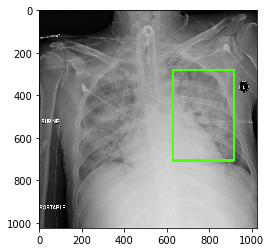

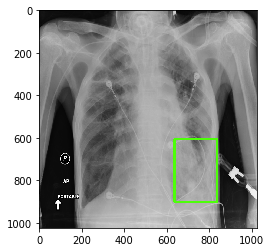

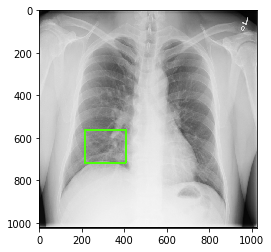

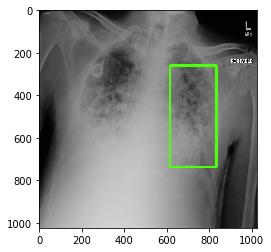

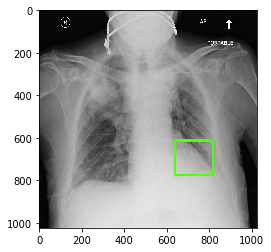

In [4]:
# show a few test image detection example
def visualize(count): 
    #count=1
    for idx, data in enumerate(dataloader_test):
        patientId = os.path.splitext(os.path.basename(data['names'][0]))[0]
        #print(patientId)
        ds = pydicom.read_file(data['names'][0])
        # original image 
        image = ds.pixel_array
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
        with torch.no_grad():
            st = time.time()
            try:
                scores, classification, transformed_anchors = retinanet(data['img'].cuda().float())
                #print('Elapsed time: {}'.format(time.time()-st))
                idxs = np.where(scores>0.5)
                img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()

                img[img<0] = 0
                img[img>255] = 255

                img = np.transpose(img, (1, 2, 0))
                resize_factor = 2 #输入的是512，原图像是1024
                if idxs[0].shape[0] > 0:
                    count -= 1
                    if count < 0:
                        break#只显示count张图像
                else:
                    continue
                for j in range(idxs[0].shape[0]):
                    bbox = transformed_anchors[idxs[0][j], :]
                    x1 = int(bbox[0]*resize_factor)
                    y1 = int(bbox[1]*resize_factor)
                    x2 = int(bbox[2]*resize_factor)
                    y2 = int(bbox[3]*resize_factor)
                    
                    cv2.rectangle(image, (x1, y1), (x2, y2),(77, 255, 9),10)
                    width = x2 - x1 
                    height = y2 - y1 
                    print("x {} y {} h {} w {}".format(x1, y1, width, height))
                plt.figure() 
                plt.imshow(image, cmap=plt.cm.gist_gray)
                #plt.savefig(patientId+".png")
            except Exception as e:
                print(e)
                continue
visualize(5)#显示5张有肺炎的图像

In [3]:
import numpy as np
# helper function to calculate IoU
def iou(box1, box2):
    x11, y11, w1, h1 = box1
    x21, y21, w2, h2 = box2
    #assert w1 * h1 > 0
    #assert w2 * h2 > 0
    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union
    
# simple test
box1 = [100, 100, 200, 200]
box2 = [100, 100, 300, 200]
print(iou(box1, box2))
def map_iou(boxes_true, boxes_pred, scores, thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75],min_conf=0):
    """
    Mean average precision at differnet intersection over union (IoU) threshold
    
    input:
        boxes_true: Mx4 numpy array of ground true bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        boxes_pred: Nx4 numpy array of predicted bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        scores:     length N numpy array of scores associated with predicted bboxes
        thresholds: IoU shresholds to evaluate mean average precision on
    output: 
        map: mean average precision of the image
    """
    
    # According to the introduction, images with no ground truth bboxes will not be 
    # included in the map score unless there is a false positive detection (?)
        
    # return None if both are empty, don't count the image in final evaluation (?)
    if len(boxes_true) == 0 or len(boxes_pred) == 0:
        return 0
    
    assert boxes_true.shape[1] == 4 or boxes_pred.shape[1] == 4, "boxes should be 2D arrays with shape[1]=4"
    if len(boxes_pred):
        assert len(scores) == len(boxes_pred), "boxes_pred and scores should be same length"
        # sort boxes_pred by scores in decreasing order
        scores = np.array(scores)
        boxes_pred = boxes_pred[scores>=min_conf]
        scores = scores[scores>=min_conf]
        boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]
        
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return 0
    
    map_total = 0
    
    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = iou(bt, bp)
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1 # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1 # bt has no match, count as FN
                
        fp = len(boxes_pred) - len(matched_bt) # FP is the bp that not matched to any bt
        m = tp / (tp + fn + fp)
        map_total += m
    
    return map_total / len(thresholds)
# simple test
boxes_true = np.array([[100, 100, 200, 200]])
boxes_pred = np.array([[100, 100, 300, 200]])
scores = [0.9]

map_iou(boxes_true, boxes_pred, scores)



0.6666666666666666


0.75

In [5]:
import pandas as pd
filepath = "/data/krf/dataset/stage_1_test_labels.csv"
df = pd.read_csv(filepath)
sum_ = 0.0
count = 0
for idx, data in enumerate(dataloader_test):
    patientId = os.path.splitext(os.path.basename(data['names'][0]))[0]
    print(patientId)
    results = df[df["patientId"]==patientId].values
    boxes_true = np.array([])
    if results[0][5] == 1:
        
        boxes_true = results[:,1:5]
        #print(boxes_true)
        boxes_true = np.array(boxes_true)
        boxes_true = boxes_true.astype(np.int)
    print("boxes_true:",boxes_true)
    boxes_pred = []
    ss = []
    with torch.no_grad():
            st = time.time()
            try:
                scores, classification, transformed_anchors = retinanet(data['img'].cuda().float())
                #print('Elapsed time: {}'.format(time.time()-st))
                idxs = np.where(scores>0.5)
                img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()

                img[img<0] = 0
                img[img>255] = 255

                img = np.transpose(img, (1, 2, 0))
                
                resize_factor = 2 #输入的是512，原图像是1024
                for j in range(idxs[0].shape[0]):
                    bbox = transformed_anchors[idxs[0][j], :]
                    x1 = int(bbox[0]*resize_factor)
                    y1 = int(bbox[1]*resize_factor)
                    x2 = int(bbox[2]*resize_factor)
                    y2 = int(bbox[3]*resize_factor)
                    #label_name = dataset_val.labels[int(classification[idxs[0][j]])]
                    #draw_caption(img, (x1, y1, x2, y2), "1")

                    #cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)
                    #print(label_name)
                    width = x2 - x1;
                    height = y2 - y1
                    boxes_pred.append([x1,y1,width,height])
                    s = scores[idxs[0][j]].cpu().numpy()
                    print("score:",s)
                    ss.append(s)
                boxes_pred = np.array(boxes_pred)
                if idxs[0].shape[0] > 0:
                    boxes_pred = boxes_pred.astype(np.int)
                print("boxes_pred:",boxes_pred)
                
                if len(boxes_true) > 0 or len(boxes_pred) > 0:
                    count += 1
                    
                iou_ = map_iou(boxes_true,boxes_pred,ss)
                print("iou:",iou_)
                
                sum_ += iou_
            except Exception as e:
                print(e)
                continue 
print(count)
print("LB score:",sum_/count)

c12aafdd-4d21-4cd3-a2ae-007bce2e2fc0
boxes_true: [[606 355 216 368]]


/data/krf/anaconda/anaconda3/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


score: 0.60543025
boxes_pred: [[592 362 202 370]]
iou: 1.0
22ce653c-e7f4-45d5-9c5e-4abdc753b1b0
boxes_true: [[647 421 142 223]
 [279 560 149 152]]
score: 0.50920206
boxes_pred: [[269 547 150 162]]
iou: 0.5
1b440724-2e24-4124-b7c7-0bc82015a674
boxes_true: []
boxes_pred: []
iou: 0
03e4827c-7338-4de3-9ac6-8831ba5637e9
boxes_true: [[310 388 140 133]]
score: 0.6746663
boxes_pred: [[308 377 135 143]]
iou: 1.0
2a740d72-0dc4-4439-93ed-60cad708d7c4
boxes_true: []
boxes_pred: []
iou: 0
131caf9c-9b7f-46cb-a18e-d9c331159d6f
boxes_true: []
boxes_pred: []
iou: 0
03cf39fd-692c-46db-80d2-f1efb09b0e31
boxes_true: []
boxes_pred: []
iou: 0
28bb0cb8-6f05-4c48-a2bf-251a1297e380
boxes_true: []
boxes_pred: []
iou: 0
232f6bcd-2006-459a-9b30-b51beea28044
boxes_true: [[602 421 197 148]]
score: 0.7156181
boxes_pred: [[583 408 233 166]]
iou: 1.0
19c705ea-6af7-48f2-a2e7-f500ef840280
boxes_true: [[144 663 214 155]
 [582 449 283 430]]
score: 0.59864026
score: 0.52283525
boxes_pred: [[591 391 297 520]
 [120 650 260 1

126de93a-1209-428c-aa3d-790991cd14e5
boxes_true: []
boxes_pred: []
iou: 0
04f9bcc7-8886-4e1a-a938-122d3a065e12
boxes_true: [[297 470 127 160]]
score: 0.54460734
boxes_pred: [[298 462 132 164]]
iou: 1.0
02f1ea1a-375f-4d1a-bac5-dd7a4b41fdbc
boxes_true: []
boxes_pred: []
iou: 0
0488a028-fb77-46e1-85fb-f0b86cf57fee
boxes_true: [[241 452 123  70]]
score: 0.5991158
boxes_pred: [[245 449 121  75]]
iou: 1.0
30bf351b-3713-42db-95cb-b668b439d46a
boxes_true: []
boxes_pred: []
iou: 0
000924cf-0f8d-42bd-9158-1af53881a557
boxes_true: []
boxes_pred: []
iou: 0
26f86e0f-62b6-44c4-8463-4d0bd24df95b
boxes_true: []
boxes_pred: []
iou: 0
2809dd67-ff4a-4508-9e50-54c6f060535f
boxes_true: []
boxes_pred: []
iou: 0
2e1956e1-8430-48d7-9888-910934acd22b
boxes_true: [[613 440 247 201]
 [191 473 171 135]]
score: 0.7274689
boxes_pred: [[182 475 203 121]]
iou: 0.5
2c0fa3c1-f701-4b25-b9f6-34a10ae2508f
boxes_true: []
boxes_pred: []
iou: 0
2c781913-5f24-4b0e-959c-6b7385c6fce0
boxes_true: [[652 652 113 153]
 [160 634 237

boxes_pred: []
iou: 0
12fa16c8-81ed-4faa-baa4-ba9c1878c279
boxes_true: []
boxes_pred: []
iou: 0
03a512bc-1162-404e-8c71-dc9e0dc7258f
boxes_true: [[815 604  56  82]]
score: 0.54657686
boxes_pred: [[806 577 104 112]]
iou: 0.0
27fa7496-e222-4016-8d1a-5a8dd4db52ed
boxes_true: [[132 310 269 445]
 [536 275 263 458]]
score: 0.58214545
score: 0.5529898
boxes_pred: [[154 296 256 476]
 [545 246 260 503]]
iou: 1.0
c0801452-425d-4196-b369-8abd70fa3268
boxes_true: []
score: 0.82438153
boxes_pred: [[299 463 162 151]]
iou: 0
1d1968e2-88a5-4d72-9237-caf4cbad9423
boxes_true: []
boxes_pred: []
iou: 0
27d43d8a-ffe0-41b6-a96a-3182901c1fe7
boxes_true: []
boxes_pred: []
iou: 0
12f231d5-3a76-48ca-8fda-35f7fc382075
boxes_true: []
boxes_pred: []
iou: 0
0e2abdaa-d654-4824-abaa-9d6fe5b67a95
boxes_true: []
boxes_pred: []
iou: 0
11a4ad3f-7899-4c3c-a88d-f1c799ec04df
boxes_true: [[593 496 260 270]
 [182 313 264 432]]
score: 0.5343446
score: 0.5081006
boxes_pred: [[205 337 251 461]
 [599 360 248 425]]
iou: 0.70833333

score: 0.54725116
boxes_pred: [[159 330 214 362]]
iou: 0.25
1c049d3b-394b-47d6-9b54-405d46db1ad7
boxes_true: [[654 433  95 118]]
score: 0.6926602
boxes_pred: [[649 435 105 141]]
iou: 0.875
19a62d7a-3d7d-4b5b-8dca-3247af94f339
boxes_true: [[262 317 159 225]]
score: 0.67226744
boxes_pred: [[257 298 161 251]]
iou: 1.0
0010f549-b242-4e94-87a8-57d79de215fc
boxes_true: []
boxes_pred: []
iou: 0
05b2d676-777a-4a4d-82ab-bf3f5f9b4d60
boxes_true: [[558 144 193 388]]
score: 0.6443698
boxes_pred: [[511 103 270 477]]
iou: 0.5
1a4326c3-303c-4140-8747-ae962f87a981
boxes_true: []
boxes_pred: []
iou: 0
2b7d7f99-ab62-4335-978e-8b8523db2fd5
boxes_true: []
boxes_pred: []
iou: 0
1d3e4775-9d2c-4e5f-81de-ce29b540a9f7
boxes_true: []
boxes_pred: []
iou: 0
0ecc15e9-fe6a-47ff-a622-43e23c8a73ff
boxes_true: []
boxes_pred: []
iou: 0
2a52de75-f306-4615-ba64-61585c8e016b
boxes_true: []
boxes_pred: []
iou: 0
1fa87ba3-8da3-4248-9245-4286c2434f69
boxes_true: []
boxes_pred: []
iou: 0
2392ac11-428d-4739-9ac7-d170aedd262d
b

1d80b0ab-2dfe-4d28-bb01-e0b60a3ce972
boxes_true: []
boxes_pred: []
iou: 0
25465a29-78c4-44cf-984d-b3b9477f2de2
boxes_true: [[207 445 143 314]
 [580 479 179 310]]
score: 0.55894387
score: 0.55439687
boxes_pred: [[563 357 273 519]
 [162 291 279 519]]
iou: 0.0
1caf1ab4-68ee-4b55-ba89-1c3f3bee1435
boxes_true: [[634 702 183 205]]
boxes_pred: []
iou: 0
0fa65909-6ed6-4773-a968-37b1a08f1768
boxes_true: []
boxes_pred: []
iou: 0
14d6efa1-b137-40c0-bc77-d512b2ed0695
boxes_true: []
boxes_pred: []
iou: 0
049f7858-3eb5-46a6-a3f9-d19013ea9228
boxes_true: []
boxes_pred: []
iou: 0
02475a31-ed48-4ff3-b401-5d74694bff8d
boxes_true: [[134 472 145 197]
 [835 474 112 172]]
boxes_pred: []
iou: 0
304a94f8-b5cf-4bef-ab88-ad9edbb7e68e
boxes_true: []
boxes_pred: []
iou: 0
1f929e8d-0289-4712-806b-8894c2ba2f93
boxes_true: []
boxes_pred: []
iou: 0
134bc526-8ebb-4419-9274-e2249fb3623f
boxes_true: []
boxes_pred: []
iou: 0
c1f7889a-9ea9-4acb-b64c-b737c929599a
boxes_true: [[570 393 261 345]
 [233 424 201 356]]
score: 0.

boxes_pred: []
iou: 0
2ed06be4-9f0e-4256-b8bf-a4b396cc6364
boxes_true: []
boxes_pred: []
iou: 0
309c2bb5-826b-4e7d-9bdb-9808d9450064
boxes_true: []
boxes_pred: []
iou: 0
1e851877-2e99-4955-8ecb-5997fe027948
boxes_true: []
boxes_pred: []
iou: 0
2ab70125-b741-487a-9f06-12a66018dc5e
boxes_true: []
boxes_pred: []
iou: 0
27bdb2cc-9665-40ea-a6b4-248a1112dbe8
boxes_true: [[676 588 203 275]]
boxes_pred: []
iou: 0
14b2868e-e0fc-40f2-a54e-609bf24da493
boxes_true: [[108 466 253 119]]
score: 0.6417161
boxes_pred: [[140 480 222  93]]
iou: 0.75
13fce2c5-6834-485f-8280-c3b0c1b952b5
boxes_true: [[244 479 217 195]]
boxes_pred: []
iou: 0
10f2cb81-ad90-4857-a2f7-18e7d8f66907
boxes_true: [[241 659 141 113]
 [653 631 155 142]]
boxes_pred: []
iou: 0
2598d635-68d5-40a8-9229-f8f242592a0a
boxes_true: []
score: 0.56089294
boxes_pred: [[687 502 186 108]]
iou: 0
277238ab-2bbf-447e-b083-f3a708c9ab2a
boxes_true: []
boxes_pred: []
iou: 0
3066b0e3-9a51-4628-bc5f-82dc78c9d558
boxes_true: [[640 350 217 346]
 [281 403 1

03946ed8-d581-4403-b052-753820035d6d
boxes_true: []
boxes_pred: []
iou: 0
c0dd2290-7dc1-4589-8061-57dfdfa23a4c
boxes_true: []
boxes_pred: []
iou: 0
c106ddba-42f7-440c-9ba9-f3fa6692f06f
boxes_true: [[753 742 185 241]
 [630 165 293 434]]
boxes_pred: []
iou: 0
0ffa20d5-7419-4c75-b821-be920771d2d4
boxes_true: []
boxes_pred: []
iou: 0
13aa11f7-b15f-47d4-94c1-4ded9bc8ab16
boxes_true: [[228 627 265 210]
 [621 511 204 249]]
score: 0.5309684
boxes_pred: [[599 394 245 394]]
iou: 0.1875
201fe232-cebb-4e8d-ab9a-f41f03bd676a
boxes_true: [[167 481 266 376]]
boxes_pred: []
iou: 0
303c2367-2911-4e0a-8b63-24f01c94b217
boxes_true: []
boxes_pred: []
iou: 0
14aee86e-0d8f-4fc3-b3ec-7ca26fc782bc
boxes_true: []
boxes_pred: []
iou: 0
21aea18e-5904-4663-9d36-54a43b90e4d8
boxes_true: []
boxes_pred: []
iou: 0
28a2d8aa-9e29-48d4-b1e3-029e3451ce0b
boxes_true: [[200 213 220 583]
 [583 235 257 570]]
score: 0.64096373
score: 0.5856773
boxes_pred: [[561 237 236 516]
 [195 220 223 534]]
iou: 0.8333333333333333
045df9bb

30b23b86-4328-4dc0-a763-350f2d7dc85f
boxes_true: []
boxes_pred: []
iou: 0
0361ea80-0215-4bbe-9bca-908ea7c4f8b6
boxes_true: [[646 412 149 333]
 [259 452 117 164]]
boxes_pred: []
iou: 0
2f34acfd-e6bd-46ec-b575-4efa1df5ff8a
boxes_true: []
boxes_pred: []
iou: 0
269afae5-82da-4c2d-878b-d9e08965bf33
boxes_true: []
boxes_pred: []
iou: 0
c003fdb7-d3ca-4295-92a8-03b32bffc780
boxes_true: []
boxes_pred: []
iou: 0
0d8cddcf-45bf-415e-b365-1dcb29baa0de
boxes_true: []
boxes_pred: []
iou: 0
313677e1-a894-4abc-814c-42ce8ab44dde
boxes_true: []
boxes_pred: []
iou: 0
03cf9ba9-dfbe-47b9-aa96-3e69432d73c3
boxes_true: []
boxes_pred: []
iou: 0
1accb591-63ca-462d-8bd8-83be3cb91df2
boxes_true: [[655 598 227 133]]
score: 0.65897644
boxes_pred: [[630 574 266 169]]
iou: 0.75
c1e228e4-b7b4-432b-a735-36c48fdb806f
boxes_true: []
score: 0.7778025
boxes_pred: [[253 493 150 118]]
iou: 0
255bd0b6-8c03-4eac-8275-941ced8de709
boxes_true: []
boxes_pred: []
iou: 0
0fc18a4c-0666-4287-a25d-e295bcb18351
boxes_true: []
boxes_pre

boxes_pred: []
iou: 0
002cb550-2e31-42f1-a29d-fbc279977e71
boxes_true: [[176 342 170 239]
 [515 333 167 251]]
score: 0.5258476
boxes_pred: [[153 323 199 285]]
iou: 0.4375
0fac1fec-6e05-48b6-bf0d-fd5148e4a6ff
boxes_true: []
boxes_pred: []
iou: 0
05905ac6-1b8f-4793-a7d2-ac794b1bb2ff
boxes_true: []
boxes_pred: []
iou: 0
2554df23-d5d3-4ffc-86c7-952a535998fc
boxes_true: [[662 392 203 327]
 [298 306 162 354]]
score: 0.64033777
score: 0.5915238
boxes_pred: [[627 264 278 548]
 [254 232 241 499]]
iou: 0.16666666666666666
1b167f33-a18a-4aab-8a29-2a9d1d41c054
boxes_true: [[603 564 184 141]]
score: 0.67157817
boxes_pred: [[606 548 221 133]]
iou: 0.625
000db696-cf54-4385-b10b-6b16fbb3f985
boxes_true: [[316 318 170 478]
 [660 375 146 402]]
score: 0.521212
boxes_pred: [[290 335 206 438]]
iou: 0.5
1a32542e-bc47-4703-82a7-d88bedc8c07d
boxes_true: [[219 300 161 174]
 [622 411 217 103]]
score: 0.5826984
score: 0.51147825
boxes_pred: [[207 312 210 172]
 [730 407 123  87]]
iou: 0.24999999999999997
1ffee791

boxes_pred: []
iou: 0
2fa8e28a-dce6-4c68-8bb6-b2537476577d
boxes_true: [[686 307 171 360]]
score: 0.5995493
boxes_pred: [[651 186 270 616]]
iou: 0.0
02c7fec6-46d9-480a-9ccc-edccfbbb44ab
boxes_true: []
boxes_pred: []
iou: 0
152f7c75-b645-4662-91c6-234d79ffeb02
boxes_true: []
boxes_pred: []
iou: 0
1ccf9c68-7db2-4170-b118-2b390c4bac7d
boxes_true: []
boxes_pred: []
iou: 0
223d7974-cb7f-47bb-9502-d91b363153dc
boxes_true: []
boxes_pred: []
iou: 0
2050fb88-70cb-40db-810d-038337613147
boxes_true: [[577 401 285 318]
 [146 389 290 286]]
score: 0.5764941
boxes_pred: [[577 386 282 336]]
iou: 0.5
22da0004-e69d-49c5-bde5-252ab5895da0
boxes_true: []
boxes_pred: []
iou: 0
0567d70b-5a94-4363-a162-7207ffaff023
boxes_true: [[220 420 166 169]
 [685 630 134 140]]
boxes_pred: []
iou: 0
20a80eb6-1110-4833-8efc-e2cc08adfe9a
boxes_true: []
boxes_pred: []
iou: 0
1ba15f4b-4b0e-4d13-8937-fd3e0d34babe
boxes_true: []
score: 0.5331219
boxes_pred: [[204 570 220 174]]
iou: 0
c04f9256-7358-42ef-b843-19dbf64ef287
boxes_

score: 0.5480277
boxes_pred: [[152 534 252 195]]
iou: 0.5
1dad3414-88c9-4c56-af5d-3a1488af452c
boxes_true: [[210 432 141 208]
 [633 466 206 270]]
score: 0.54267085
score: 0.51954275
boxes_pred: [[596 279 290 620]
 [189 373 228 355]]
iou: 0.0
2eeca9b5-d14f-46c6-ac7e-f676ee83e6be
boxes_true: []
boxes_pred: []
iou: 0
1079ba63-0681-45b7-b1da-fe11ede2b9ae
boxes_true: []
boxes_pred: []
iou: 0
239b10e6-a859-447b-8496-eca7b6c8a356
boxes_true: [[226 536 160 235]]
score: 0.6033986
boxes_pred: [[206 515 226 278]]
iou: 0.5
2d232afa-67dc-4a77-bf1a-665e2531f634
boxes_true: []
boxes_pred: []
iou: 0
108a989d-bd99-4e96-8ce6-ab21ffd0d79f
boxes_true: []
boxes_pred: []
iou: 0
303390de-3812-4aae-893f-3f18897a6c21
boxes_true: [[569 603 197 107]
 [204 551 203 156]]
score: 0.5196141
boxes_pred: [[208 573 197 135]]
iou: 0.5
1fd15b31-7b21-483d-bbef-e9893d6a051b
boxes_true: [[675 430 169 123]]
score: 0.740711
boxes_pred: [[661 418 192 135]]
iou: 1.0
2a1f4a9f-7b41-4f50-bce3-abd130a42a69
boxes_true: []
boxes_pred:

boxes_pred: []
iou: 0
28c94c54-4279-431a-b329-c69104ee0d38
boxes_true: [[628 501 182 157]]
score: 0.719446
boxes_pred: [[657 496 183 144]]
iou: 0.625
2bd138cb-a07a-48b9-bbc9-137a460e1e2d
boxes_true: []
boxes_pred: []
iou: 0
23ab8dcb-0331-42b0-8058-45676e48675e
boxes_true: [[205 523 195 211]]
score: 0.53763247
boxes_pred: [[209 533 204 188]]
iou: 1.0
14df3d5a-f3fd-4a64-ae75-5a9610575e11
boxes_true: [[301 294 121 429]
 [609 362 191 388]]
boxes_pred: []
iou: 0
1a63ca9b-22c9-4856-960f-7cdca38bdfd9
boxes_true: []
score: 0.7622966
boxes_pred: [[116 434 248 186]]
iou: 0
1a2dc891-713d-4253-ad19-a1e7910ee2eb
boxes_true: [[576 651 166 206]
 [314 649 123 189]]
boxes_pred: []
iou: 0
c1f6b555-2eb1-4231-98f6-50a963976431
boxes_true: []
score: 0.60226107
boxes_pred: [[215 563 192 154]]
iou: 0
120fd100-b447-4ec9-b4fe-3cdd3f0496e9
boxes_true: [[203 443 228 403]
 [534 366 301 565]]
boxes_pred: []
iou: 0
19f688c5-33bc-4fa3-ae34-7cf1fbd06eb5
boxes_true: [[258 460  98 244]
 [593 455 121 268]]
boxes_pred: [

In [5]:
LB score: 0.2873160302307082 count=419 加入了训练图片
为什么会有iou=1.0的情况？？？ 当iou >= 0.75，则 map_iou=1


353


0.912230528917142
